# Multi-layer perceptron

In [2]:
import torch
import matplotlib.pyplot as plt

## Common activation functions

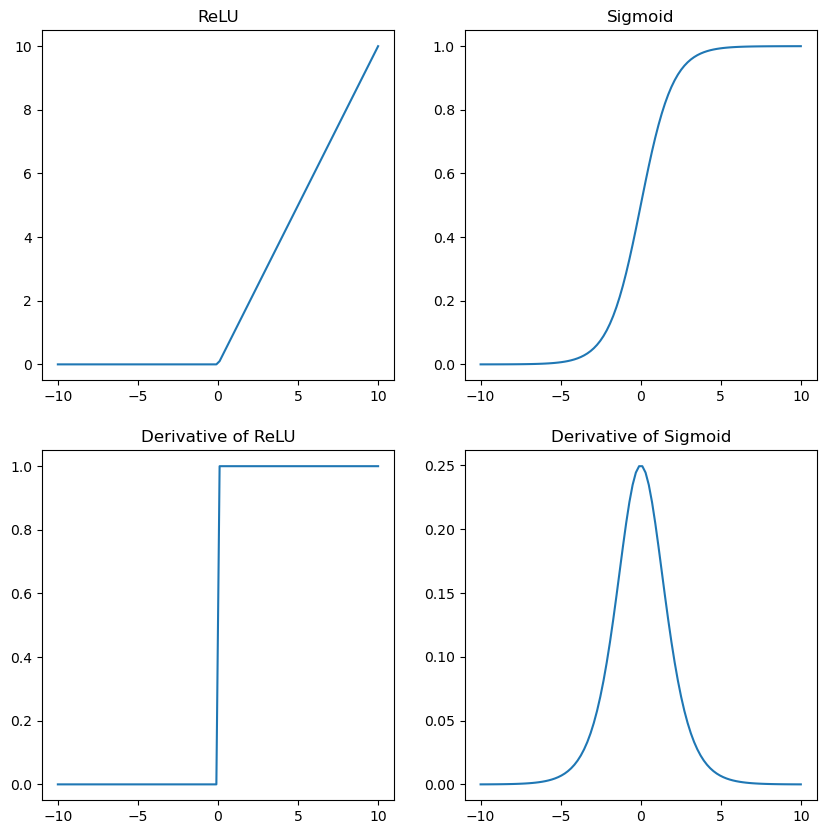

In [2]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

funcs = {
    'ReLU': lambda x: torch.max(x, torch.zeros_like(x)),
    'Sigmoid': lambda x: 1 / (1 + torch.exp(-x))
}
    
for (func_name, func), ax in zip(funcs.items(), axes.T):
    x = torch.linspace(-10, 10, 100, requires_grad=True)
    y = func(x)
    ax[0].plot(x.detach(), y.detach())
    ax[0].set_title(f"{func_name}")
    y.backward(torch.ones_like(y))
    ax[1].set_title(f"Derivative of {func_name}")
    ax[1].plot(x.detach(), x.grad)

## MLP classifier

In [35]:
import torch
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import cross_entropy, softmax, sigmoid, binary_cross_entropy

class MLPClassifierScratch:

    def __init__(self, layers=[1, 2, 1], eta=1e-4, patience=1e-4, n_iter_no_change=10, max_iter=200, batch_size=32, alpha=0.1):
        self.eta = eta
        self.alpha = alpha
        self.patience = patience
        self.n_iter_no_change = n_iter_no_change
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.activation = lambda x: torch.max(x, torch.zeros_like(x))
        self.layers = []
        for i in range(len(layers)-1):
            self.layers.append(dict())
            self.layers[i][f"w"] = torch.normal(0, 0.1, size=[layers[i], layers[i+1]], dtype=torch.float32, requires_grad=True)
            self.layers[i][f"b"] = torch.normal(0, 0.1, size=[1, layers[i+1]], dtype=torch.float32, requires_grad=True)
        self.train_losses = None
        self.val_losses = None

    def predict(self, X: torch.Tensor):

        y = X
        for layer in self.layers[:-1]:
            y = (y - torch.mean(y, dim=0)) / torch.std(y, dim=0)
            # ymin = torch.min(y, dim=0).values
            # ymax = torch.max(y, dim=0).values
            # y = (y - ymin)/(ymax - ymin)

            w = layer['w']
            b = layer['b']
            y = self.activation(torch.matmul(y, w) + b)

        w = self.layers[-1]['w']
        b = self.layers[-1]['b']
        z = torch.matmul(y, w) + b
        
        
        if z.shape[1] == 1:
            y = sigmoid(z)
        else:
            y = softmax(z, dim=1)

        return y

    def accuracy(self, X: torch.Tensor, y: torch.Tensor):
        if len(y.shape) > 1 and y.shape[1] > 1:
            return torch.sum(self.predict(X).argmax(dim=1) == y.argmax(dim=1)) / y.shape[0]
        else:
            y_pred = (self.predict(X) > 0.5)*1
            return torch.sum(y_pred == y) / y.shape[0]
    
    def loss_function(self, y_true, y_pred):
        if y_true.shape[1] == 1:
            return binary_cross_entropy(y_pred, y_true)
        else:
            return cross_entropy(y_pred, y_true)

    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.train_losses = []
        self.val_losses = []

        parameters = [p for l in self.layers for p in l.values()]
        optimizer = SGD(parameters, self.eta)

        y = y.reshape(-1, 1) if len(y.shape) == 1 else y
        dataset = torch.cat([X, y], dim=1).type(torch.float32)
        train_set, val_set = random_split(dataset, [0.9, 0.1])
        train_dataloader = DataLoader(train_set, self.batch_size, shuffle=True)

        no_change_in_loss = []

        for _ in range(self.max_iter):
            
            batch_loss = []
            for batch in train_dataloader:
                batch_X = batch[:, :-y.shape[1]]
                batch_y = batch[:, -y.shape[1]:]
                
                optimizer.zero_grad()
                y_pred = self.predict(batch_X)
                loss = self.loss_function(batch_y, y_pred)

                batch_loss.append(loss.item())
                
                with torch.no_grad():
                    loss.backward()
                    optimizer.step()

            self.train_losses.append(sum(batch_loss) / len(batch_loss))
            
            with torch.no_grad():
                val_X = val_set[:][:, :-y.shape[1]]
                val_y = val_set[:][:, -y.shape[1]:]
                y_pred = self.predict(val_X)
                val_loss = self.loss_function(val_y, y_pred)
                self.val_losses.append(val_loss.item())
            
            # if for self.n_iter_no_change consecutive iterations, the change is less than self.patience, then stop
            if len(self.val_losses) >= self.n_iter_no_change and self.val_losses[-2] - self.val_losses[-1] < self.patience:
                no_change_in_loss.append(True)
                if len(no_change_in_loss) == self.n_iter_no_change: 
                    if all(no_change_in_loss): break
                    no_change_in_loss = []

        return self

### Iris example

In [36]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.nn.functional import one_hot

dataset = load_iris()

X = torch.tensor(dataset.data, dtype=torch.float32)
y = one_hot(torch.tensor(dataset.target).long(), num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([120, 4]),
 torch.Size([30, 4]),
 torch.Size([120, 3]),
 torch.Size([30, 3]))

tensor(0.9333)

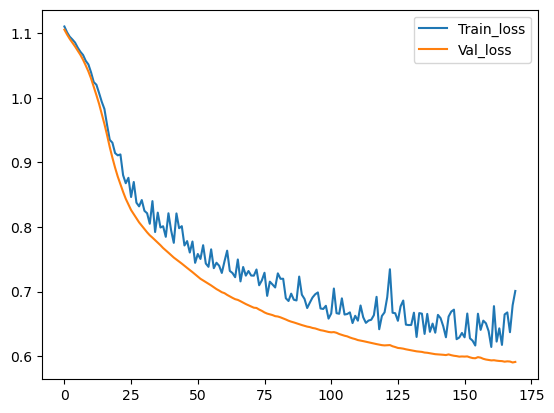

In [39]:
mlp = MLPClassifierScratch(layers=[4, 16, 3], eta=0.1, batch_size=32, patience=1e-5, max_iter=500)
mlp.fit(X_train, y_train)

plt.plot(mlp.train_losses, label='Train_loss')
plt.plot(mlp.val_losses, label='Val_loss')

plt.legend()

mlp.accuracy(X_test, y_test)

### Breast cancer example

In [40]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

X = torch.tensor(dataset.data, dtype=torch.float32)
y = torch.tensor(dataset.target).reshape(-1, 1).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([455, 30]),
 torch.Size([114, 30]),
 torch.Size([455, 1]),
 torch.Size([114, 1]))

tensor(0.9825)

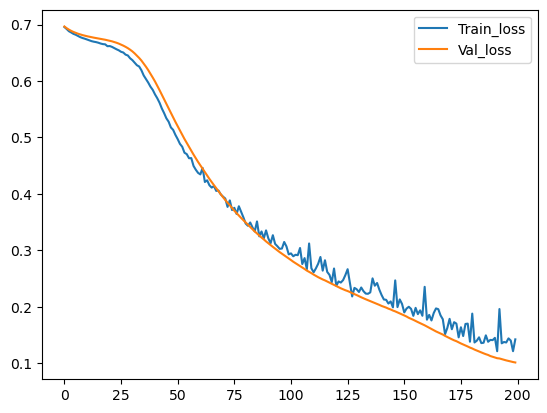

In [44]:
mlp = MLPClassifierScratch(layers=[30, 2, 1], eta=0.01, patience=1e-5, n_iter_no_change=20, batch_size=32, max_iter=200)
mlp.fit(X_train, y_train)

plt.plot(mlp.train_losses, label='Train_loss')
plt.plot(mlp.val_losses, label='Val_loss')

plt.legend()

mlp.accuracy(X_test, y_test)

## MLP using torch primitives

In [7]:
import torch
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import cross_entropy, softmax, sigmoid, binary_cross_entropy

class MLPClassifierTorch:

    def __init__(self, layers=[1, 2, 1], eta=1e-4, patience=1e-4, n_iter_no_change=10, max_iter=200, batch_size=32, alpha=0.1):
        self.eta = eta
        self.alpha = alpha
        self.patience = patience
        self.n_iter_no_change = n_iter_no_change
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.activation = lambda x: torch.max(x, torch.zeros_like(x))
        network = []
        for i in range(len(layers)-2):
            network.append(torch.nn.Linear(layers[i], layers[i+1], dtype=torch.float32))
            network.append(torch.nn.ReLU())

        network.append(torch.nn.Linear(layers[-2], layers[-1], dtype=torch.float32))
        if layers[-1] == 1:
            network.append(torch.nn.Sigmoid())
        else:
            network.append(torch.nn.Softmax(dim=1))

        self.net = torch.nn.Sequential(*network)
        self.train_losses = None
        self.val_losses = None

    def predict(self, X: torch.Tensor):
        return self.net(X)

    def accuracy(self, X: torch.Tensor, y: torch.Tensor):
        if len(y.shape) > 1 and y.shape[1] > 1:
            return torch.sum(self.predict(X).argmax(dim=1) == y.argmax(dim=1)) / y.shape[0]
        else:
            y_pred = (self.predict(X) > 0.5)*1
            return torch.sum(y_pred == y) / y.shape[0]
    
    def loss_function(self, y_true, y_pred):
        if y_true.shape[1] == 1:
            return binary_cross_entropy(y_pred, y_true)
        else:
            return cross_entropy(y_pred, y_true)

    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.train_losses = []
        self.val_losses = []
        
        optimizer = SGD(self.net.parameters(), self.eta)

        y = y.reshape(-1, 1) if len(y.shape) == 1 else y
        dataset = torch.cat([X, y], dim=1).type(torch.float32)
        train_set, val_set = random_split(dataset, [0.9, 0.1])
        train_dataloader = DataLoader(train_set, self.batch_size, shuffle=True)

        no_change_in_loss = []

        for _ in range(self.max_iter):
            
            batch_loss = []
            for batch in train_dataloader:
                batch_X = batch[:, :-y.shape[1]]
                batch_y = batch[:, -y.shape[1]:]
                
                optimizer.zero_grad()
                y_pred = self.predict(batch_X)
                loss = self.loss_function(batch_y, y_pred)

                batch_loss.append(loss.item())
                
                with torch.no_grad():
                    loss.backward()
                    optimizer.step()

            self.train_losses.append(sum(batch_loss) / len(batch_loss))
            
            with torch.no_grad():
                val_X = val_set[:][:, :-y.shape[1]]
                val_y = val_set[:][:, -y.shape[1]:]
                y_pred = self.predict(val_X)
                val_loss = self.loss_function(val_y, y_pred)
                self.val_losses.append(val_loss.item())
            
            # if for self.n_iter_no_change consecutive iterations, the change is less than self.patience, then stop
            if len(self.val_losses) >= self.n_iter_no_change and self.val_losses[-2] - self.val_losses[-1] < self.patience:
                no_change_in_loss.append(True)
                if len(no_change_in_loss) == self.n_iter_no_change: 
                    if all(no_change_in_loss): break
                    no_change_in_loss = []

        return self

### Iris example

In [8]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.nn.functional import one_hot

dataset = load_iris()

X = torch.tensor(dataset.data, dtype=torch.float32)
y = one_hot(torch.tensor(dataset.target).long(), num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([120, 4]),
 torch.Size([30, 4]),
 torch.Size([120, 3]),
 torch.Size([30, 3]))

tensor(1.)

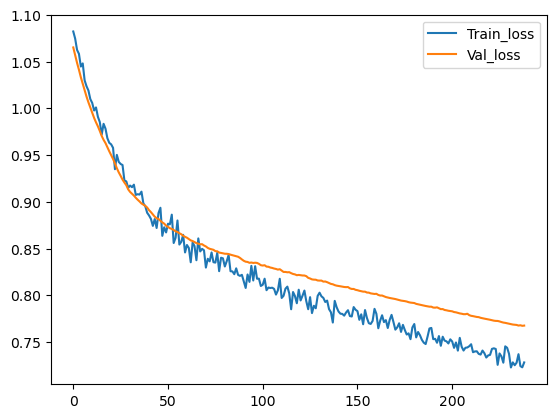

In [31]:
mlp = MLPClassifierTorch(layers=[4, 16, 3], eta=0.01, batch_size=32, n_iter_no_change=20, patience=1e-5, max_iter=500)
mlp.fit(X_train, y_train)

plt.plot(mlp.train_losses, label='Train_loss')
plt.plot(mlp.val_losses, label='Val_loss')

plt.legend()

mlp.accuracy(X_test, y_test)

### Breast cancer example

In [33]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

X = torch.tensor(dataset.data, dtype=torch.float32)
y = torch.tensor(dataset.target).reshape(-1, 1).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([455, 30]),
 torch.Size([114, 30]),
 torch.Size([455, 1]),
 torch.Size([114, 1]))

tensor(0.8684)

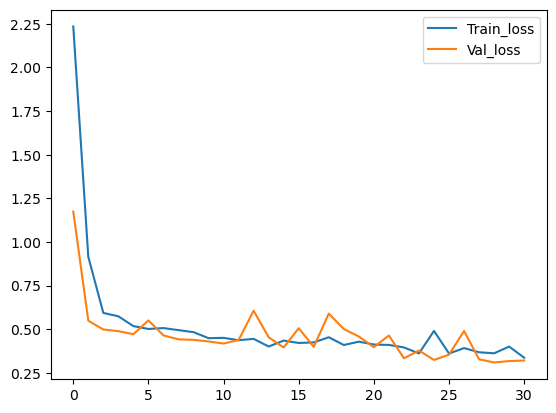

In [88]:
mlp = MLPClassifierTorch(layers=[30, 16, 8, 1], eta=0.001, patience=1e-5, n_iter_no_change=10, batch_size=32, max_iter=200)
mlp.fit(X_train, y_train)

plt.plot(mlp.train_losses, label='Train_loss')
plt.plot(mlp.val_losses, label='Val_loss')

plt.legend()

mlp.accuracy(X_test, y_test)

## Custom torch layers

In [3]:
from torch import nn
from torch.nn import functional as F

class CustomLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units, ))
        
    def forward(self, X):
        return F.relu(X @ self.weights + self.bias)

lin = CustomLinear(5, 3)
lin(torch.randn(2, 5))

tensor([[2.2787, 1.9463, 0.0000],
        [2.1667, 1.7819, 0.5593]], grad_fn=<ReluBackward0>)

## CUDA tensors

In [6]:
torch.cuda.is_available()

True

Difference between CPU and GPU (CUDA)

In [19]:
N = 10000

A = torch.randn((N, N), device='cuda')
B = torch.randn((N, N), device='cuda')

A @ B

tensor([[  48.2673,   46.0538,   46.7018,  ...,   47.5869, -156.3482,
           90.3497],
        [ 136.2136,    2.4549,   45.0254,  ...,   79.6397,  -54.6846,
          -46.8365],
        [-179.7395,  -21.8629,  224.4736,  ...,  -37.8492,   58.3387,
           44.1627],
        ...,
        [ -33.7568,  -56.5070, -215.6094,  ..., -105.5242,  -68.4364,
         -205.0652],
        [  19.2025,  -62.3195,  142.4776,  ...,   28.2702,   80.0841,
          111.4710],
        [ 154.5612,    2.2151,  108.7205,  ...,  -68.1576,  -24.1025,
           50.7877]], device='cuda:0')

In [20]:
A = torch.randn((N, N))
B = torch.randn((N, N))

A @ B

tensor([[ -85.3367, -108.6842,  -54.4327,  ...,    2.2291,  112.9643,
          -99.8272],
        [ -38.8125,  -32.5531,  -12.9203,  ...,    9.4503,   60.1381,
          -61.6562],
        [-102.5872,  -56.8850,   50.9694,  ...,   38.9836,  -78.3399,
         -134.5224],
        ...,
        [ -53.0339,   79.6713,  143.0621,  ...,  100.1721, -161.8327,
          -58.8732],
        [   8.0556,  104.0922, -172.0143,  ...,   43.7201,   53.1263,
         -141.0099],
        [-154.8757,  -74.6983,   66.2710,  ...,   39.0363,   64.8796,
          126.9835]])